## Multi-layer Perceptron from scratch

This is a Python implementation of the simplest MLP architecture, i.e., with a **single hidden layer** and single output. This simple implementation from scratch allows to fully understand how the building blocks of deep learning architecture works, specifically the **forward pass** and the **backpropagation** of gradients.

For this tutorial we follow the formalism used in [1]. Let $\Theta \in \mathbb{R}^{m \times n}$ be the weight matrices that maps the input $x \in \mathbb{R}^n$ to the hidden state and $\beta \in \mathbb{R}^{1 \times m}$ the map to the output, which is a single unit in this simple case. Biases are here omitted because they can be re-absorbed in the weight matrices by simply adding a constant value as an extra dimension of the imput vector. The output can then be re-written as

$$f_{MLP} (x; \Theta, \beta) = \sum\limits_{i=1}^m \dfrac{\beta_i}{\phi(\Theta_i \cdot x)} \;,$$

where $\phi(\Theta_i \cdot x)$ is a valid activation function. We are now left only with the definition of the loss function, which we simply take as the Mean Squared Error:

$$\mathcal{L}(x;\Theta,\beta) = \frac{1}{2} ||f_{MLP} - y||^2 \;,$$

where $y$ is the value to be reconstructed. The formalism remains unchanged when instead of a single vector $x$ a batch of $s$ element is feed-forwarded.

If the weights of the network are trained through Stochastic Gradient Descent, an efficient algorithm to compute the required derivative is the backpropagation. In this simple case we can compute the derivatives explicitly as

$$ \frac{\partial \mathcal{L}(x)}{\partial \beta_i} = (f_{MLP}-y) \; \phi(\Theta_i \cdot x) \quad \quad \quad \frac{\partial \mathcal{L}(x)}{\partial \Theta_{i,j}} = (f_{MLP}-y) \; \beta_i \; \phi'(\Theta_i \cdot x) \; x_j $$

The weight matrices can then be simply updated through SGD as

$$ \Theta \leftarrow \Theta -\eta \frac{\partial \mathcal{L}(x)}{\partial \Theta}  \quad \quad \quad  \beta \leftarrow \beta -\eta \frac{\partial \mathcal{L}(x)}{\partial \beta}$$

Let's now take a closer look at how this simple MLP is implemented. We do so fot three activation functions:

$$ \mathrm{ReLU:} \; \phi(x) := \max\{0, x\} \quad\quad\quad \mathrm{sigmoid:} \; \phi(x) := \frac{1}{1+e^{-x}} \quad\quad\quad \mathrm{tanh} \; := \frac{e^x-e^{-x}}{e^x+e^{-x}}$$

[1] Thomas Hofmann, *Deep Learning: lecture notes* (version 1.0), Computer Science, ETH Zurich, 2020

In [1]:
import numpy as np # this is all we need to make deep learning work!
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ipywidgets
from ipywidgets import interact_manual

In [2]:
# Multi-layer Perception class

class MLP:
    def __init__(self, n, m, activation:['sigmoid','tanh'], lr):
        self.theta = np.random.uniform(low=-1./n, high=1./n, size=(m,n)) # random weight initialization
        self.beta = np.random.uniform(low=-1./m, high=1./m, size=(1,m))  # random weight initialization
        self.n = n
        self.m = m
        self.lr = lr
        
        # define activation functions and their derivative
        if activation=='relu':
            self.activ = lambda x : x * (1*(x>0))
            self.activ_der = lambda x : 1*(x>0)
        elif activation=='sigmoid':
            self.activ = lambda x : 1. / (1. + np.exp(-x)) 
            self.activ_der = lambda x : 1. / (2. + np.exp(x) + np.exp(-x)) 
        elif activation=='tanh':
            self.activ = lambda x : (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
            self.activ_der = lambda x : 4. / np.square(np.exp(x) + np.exp(-x))
        else:
            raise ValueError("Activation must be one of {'relu', 'sigmoid', 'tanh'}")
        
    
    def forward(self, x):
        '''feed-forward operation: first hidden layer then output'''
        fp = {}
        fp['hidden'] = self.activ(np.dot(self.theta, x))     # m x s (= m x n @ n x s)
        fp['output'] = self.beta @ fp['hidden']              # 1 x s (= 1 x m @ m x s)
        
        return fp
    
    
    def gradient(self, x, y, fp):
        '''gradient computation: first beta and then theta'''
        grad = {}
        loss = fp['output'] - y                              # 1 x s 
        grad['beta'] = loss @ fp['hidden'].T                 # 1 x m (= 1 x s @ s x m)
        
        back_prop = self.beta.T @ loss                       # m x s (= m x 1 @ 1 x s)
        activ_der = self.activ_der(-np.dot(self.theta,x))
        sigm_der = fp['hidden'] * (1 - fp['hidden'])         # m x s
        grad['theta'] = (back_prop * activ_der) @ x.T        # m x n (= m x s @ s x n)
        
        return grad
    
    def train(self, x, y):
        '''performs a single train step'''
        fp = self.forward(x)
        loss = MSE_loss(fp['output'], y)
        
        grad = self.gradient(x, y, fp)
        self.theta = self.theta - self.lr * grad['theta']
        self.beta = self.beta - self.lr * grad['beta']
        
        return loss
    
MSE_loss = lambda x, y : np.square(x - y).mean()

In [3]:
def trigonometric_data(num_points, noise, alpha):
    x = np.random.normal(size=(num_points, 1))
    x1 = np.sin(alpha[0] * x)
    for a in range(len(alpha[1:])):
        x1 = np.concatenate((np.sin(alpha[a] * x), x1), axis=1)  # X = [x, 1].
    y = np.dot(x1, alpha) + np.random.normal(size=(num_points,)) * noise  # y = Xw + eps
    
    return x1, y

In [4]:
def plot_data (X, Y):
    fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(14,7))
    
    for row_idx in range(2):
        for col_idx in range(5):
            axs[row_idx, col_idx].scatter(X[:,row_idx+col_idx], Y, s=80, c='r', marker=".")
        
    plt.tight_layout()
    plt.show()
    
def plot_subfigs (X, Y, Y_true):
    fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(14,7))
    
    for row_idx in range(2):
        for col_idx in range(5):
            axs[row_idx, col_idx].scatter(X[:,row_idx+col_idx], Y_true, s=80, c='r', marker=".")
            axs[row_idx, col_idx].scatter(X[:,row_idx+col_idx], Y, s=80, c='b', marker=".")
        
    fig.legend(['true', 'predicted'], loc='lower right', bbox_to_anchor=(0.6,-0.05), 
               ncol=2, bbox_transform=fig.transFigure)
    
    plt.tight_layout()
    plt.show()

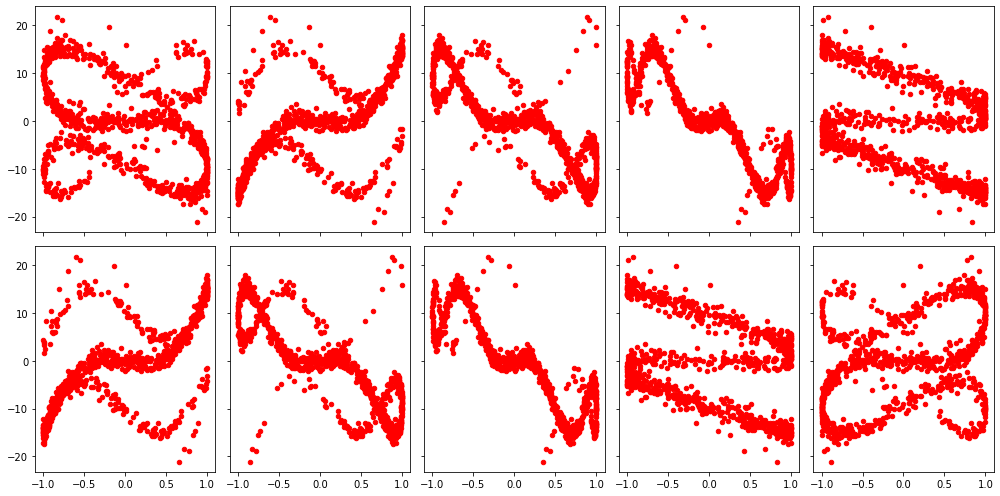

In [5]:
n_elements = 1000
alpha = np.array([-.5, 5., 1.3, -3., -6., 1., 1.5, -2., 3., 10.]) # frequency of sine functions for each dimension
X, Y = trigonometric_data(n_elements, 1, alpha)
X = np.array(X)
plot_data(X, Y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_valid = np.expand_dims(y_valid,0)
X_valid = X_valid.T

In [7]:
lr_widget = ipywidgets.FloatSlider(value=8e-5, min=5e-6, max=3e-4, step=5e-6, description='Learning rate:', 
                                   style={'description_width': 'initial'}, continuous_update=False,
                                   readout_format='.1e')
hidden_layer_size_widget = ipywidgets.IntSlider(value=10, min=1, max=100, step=1, 
                                   description='Hidden units:',
                                   style={'description_width': 'initial'}, 
                                   continuous_update=False)
n_iter_no_change_widget = ipywidgets.IntSlider(value=5, min=1, max=20, step=1, 
                                   description='Early stopping:',
                                   style={'description_width': 'initial'}, 
                                   continuous_update=False)
activation_widget = ipywidgets.RadioButtons(options=['relu', 'sigmoid', 'tanh'],
                                          value='tanh', description='Activation function:',
                                          style={'description_width': 'initial'})

def mlp_trainer(lr, hidden_layer, n_epochs_no_change, activation):
    
    MLP_relu = MLP(n=10, m=hidden_layer, activation=activation, lr=lr)
    train, valid = [], []
    n_epochs=500
    tol = 0.01
    
    try:
        
        for epoch in range(n_epochs):
            shuffle = np.random.permutation(X_train.shape[0])
            X = X_train[shuffle]
            y = y_train[shuffle]

            y = np.expand_dims(y,0)
            X = X.T

            train_loss = MLP_relu.train(X, y) 
            train.append(train_loss)
            valid_loss = MSE_loss(MLP_relu.forward(X_valid)['output'], y_valid)
            valid.append(valid_loss)
            
            if epoch > n_epochs_no_change:
                if np.array(valid[-n_epochs_no_change+1:-1]).mean() - valid[-1] < tol:
                    break
                    
        y_pred = MLP_relu.forward(X_test.T)['output']
        print('Test MSE: {:.2f}'.format(MSE_loss(y_pred, y_test)))

        plt.title('Train and validation loss')
        plt.plot(range(len(train)), train, color='b', label='train loss')
        plt.plot(range(len(valid)), valid, color='r', label='valid loss')
        plt.legend()
        plt.show()
        
        plot_subfigs(X_test, MLP_relu.forward(X_test.T)['output'], y_test)
        
    except KeyboardInterrupt:
        pass


interact = interact_manual(mlp_trainer, lr=lr_widget, hidden_layer=hidden_layer_size_widget, 
                n_epochs_no_change=n_iter_no_change_widget, activation=activation_widget)

interactive(children=(FloatSlider(value=8e-05, continuous_update=False, description='Learning rate:', max=0.00…